# Gold, Oil, NASDAQ, USD-index example

This notebook illustrates the toolkit's use on a real-world financial data set, using the weekly price of the gold, oil, the NASDAQ and an index of the USD.

For these four time series we fit three different multi-output Gaussian processes and show how they compare. For each model we optimize we repeat the experiment 5 times, to ensure robustness in the optimization and prediction.

Data sources:
- Oil: Brent daily in USD from https://www.eia.gov/dnav/pet/hist/RBRTEd.htm
- Gold: LMBA gold daily at 10:30AM in USD from https://fred.stlouisfed.org/series/GOLDAMGBD228NLBM
- NASDAQ: adjusted closing price (daily) from https://finance.yahoo.com/quote/%5EIXIC/history?p=%5EIXIC
- USD index: traded weighted on broad currency index from https://fred.stlouisfed.org/series/TWEXB

Please see our publication at https://doi.org/10.1109/ICASSP40776.2020.9054102 for a full description of this data set and the interpretations of our results.

In [1]:
import mogptk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data loading
We will load the four financial time series and put them in a single data set for MOGPTK. Next we filter for a specific time range, in this case four years, and agregate the daily measurements into weeks. Additionally, we transform the Y axis in order to make training more effective.

For each of the channels we also remove certain ranges so that we can evaluate the effectiveness of data imputation in those regions. Each trial will additionally remove data points at random in order to verify the consistency of the results.

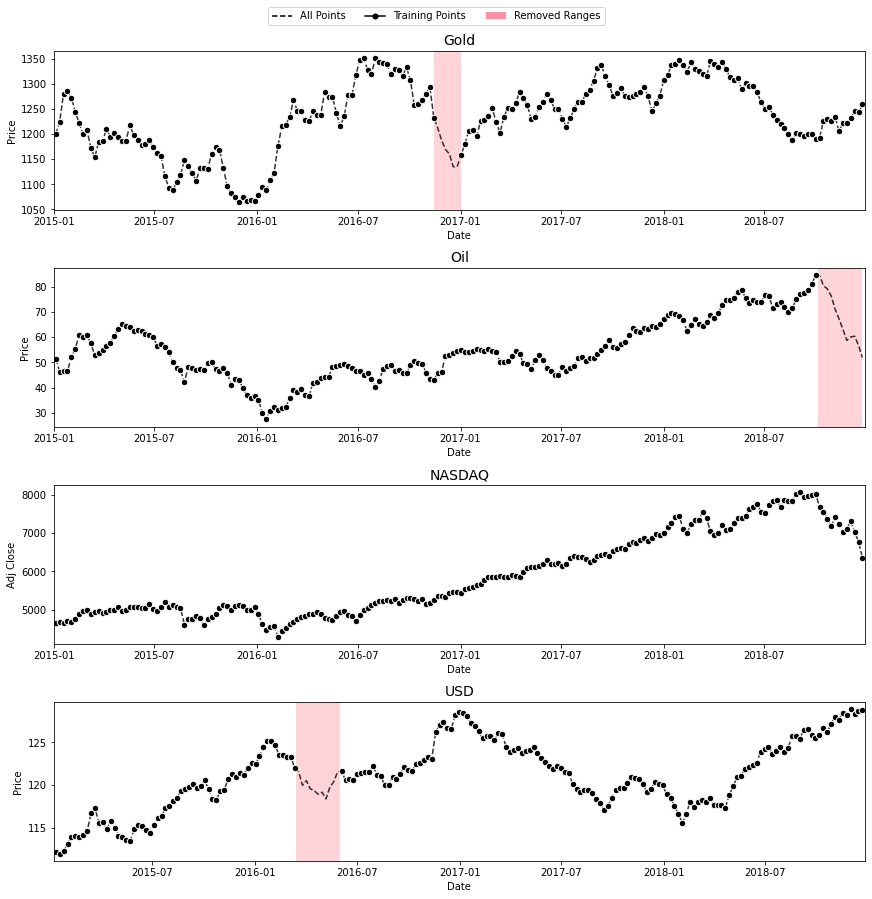

In [2]:
oil = mogptk.LoadCSV('data/gonu/brent-daily.csv', 'Date', 'Price',
                     name='Oil')
gold = mogptk.LoadCSV('data/gonu/lmba-gold-usd-am-daily.csv', 'Date',
                      'Price', name='Gold', na_values='.')
nasdaq = mogptk.LoadCSV('data/gonu/nasdaq.csv', 'Date', 'Adj Close',
                        name='NASDAQ')
usd = mogptk.LoadCSV('data/gonu/TWEXB.csv', 'Date', 'Price',
                     name='USD')
dataset = mogptk.DataSet(gold, oil, nasdaq, usd)

# Remove points randomly to simulate sensor failure
np.random.seed(1)
for i, channel in enumerate(dataset):
    channel.filter('2015-01-01', '2018-12-31')
    channel.aggregate('7D')
    
    channel.transform(mogptk.TransformLog())
    channel.transform(mogptk.TransformDetrend())
    
    name = channel.get_name()
    if name == 'Gold':
        channel.remove_range('2016-11-15', '2017-01-01')
    if name == 'Oil':
        channel.remove_range('2018-10-05', None)
    if name == 'USD':
        channel.remove_range('2016-03-15', '2016-06-01')
        
dataset.plot();

We will be using the Adam optimizer, which is known to give good results using a relatively high learning rate, and we'll run five trials for each model in order to evaluate the consistency in our results.

In [3]:
n_trials = 5
method = 'Adam'
lr = 0.1
iters = 500

## Multi-output spectral mixture kernel

In [4]:
mosm_models = []
mosm_mae = np.zeros((n_trials,4))
mosm_rmse = np.zeros((n_trials,4))
mosm_mape = np.zeros((n_trials,4))

for n in range(n_trials):
    mosm_dataset = dataset.copy()
    mosm_dataset['Gold'].remove_randomly(pct=0.6)
    mosm_dataset['Oil'].remove_randomly(pct=0.3)
    mosm_dataset['NASDAQ'].remove_randomly(pct=0.6)
    mosm_dataset['USD'].remove_randomly(pct=0.6)
    
    print('\nTrial', n+1, 'of', n_trials)
    mosm = mogptk.MOSM(mosm_dataset, Q=3)
    mosm.init_parameters('BNSE')
    mosm.train(method=method, lr=lr, iters=iters, verbose=True)
    mosm_models.append(mosm)
    print('=' * 50)
    
    error = mogptk.error(mosm, per_channel=True)[0]
    mosm_mae[n,:] = np.array([item['MAE'] for item in error])
    mosm_rmse[n,:] = np.array([item['RMSE'] for item in error])
    mosm_mape[n,:] = np.array([item['MAPE'] for item in error])
    
pd.DataFrame(np.c_[mosm_mae.mean(0), mosm_rmse.mean(0), mosm_mape.mean(0),
             mosm_mae.std(0), mosm_rmse.std(0), mosm_mape.std(0)],
             columns=['MAE', 'RMSE', 'MAPE', 'MAE std', 'RMSE std', 'MAPE std'])


Trial 1 of 5

Starting optimization using Adam
‣ Model: MOSM
‣ Channels: 4
‣ Mixtures: 3
‣ Training points: 382
‣ Parameters: 72
‣ Initial NLL: 0.980

Optimization finished in 0.74 minutes
‣ Function evaluations: 500
‣ Final NLL: 0.056

Trial 2 of 5

Starting optimization using Adam
‣ Model: MOSM
‣ Channels: 4
‣ Mixtures: 3
‣ Training points: 380
‣ Parameters: 72
‣ Initial NLL: 0.502

Optimization finished in 0.76 minutes
‣ Function evaluations: 500
‣ Final NLL: -0.049

Trial 3 of 5

Starting optimization using Adam
‣ Model: MOSM
‣ Channels: 4
‣ Mixtures: 3
‣ Training points: 381
‣ Parameters: 72
‣ Initial NLL: 0.840

Optimization finished in 0.71 minutes
‣ Function evaluations: 500
‣ Final NLL: -0.106

Trial 4 of 5

Starting optimization using Adam
‣ Model: MOSM
‣ Channels: 4
‣ Mixtures: 3
‣ Training points: 380
‣ Parameters: 72
‣ Initial NLL: 0.732

Optimization finished in 0.71 minutes
‣ Function evaluations: 500
‣ Final NLL: -0.045

Trial 5 of 5

Starting optimization using Adam
‣

,MAE,RMSE,MAPE,MAE std,RMSE std,MAPE std
0,146.732913,161.002312,11.620973,4.025401,3.168421,0.301657
1,17.159746,20.000182,28.063536,1.293031,1.506186,1.511240
2,1580.105931,1909.429598,24.426537,76.370226,68.752172,0.963272
3,3.970265,4.762520,3.230759,0.082314,0.097595,0.065383


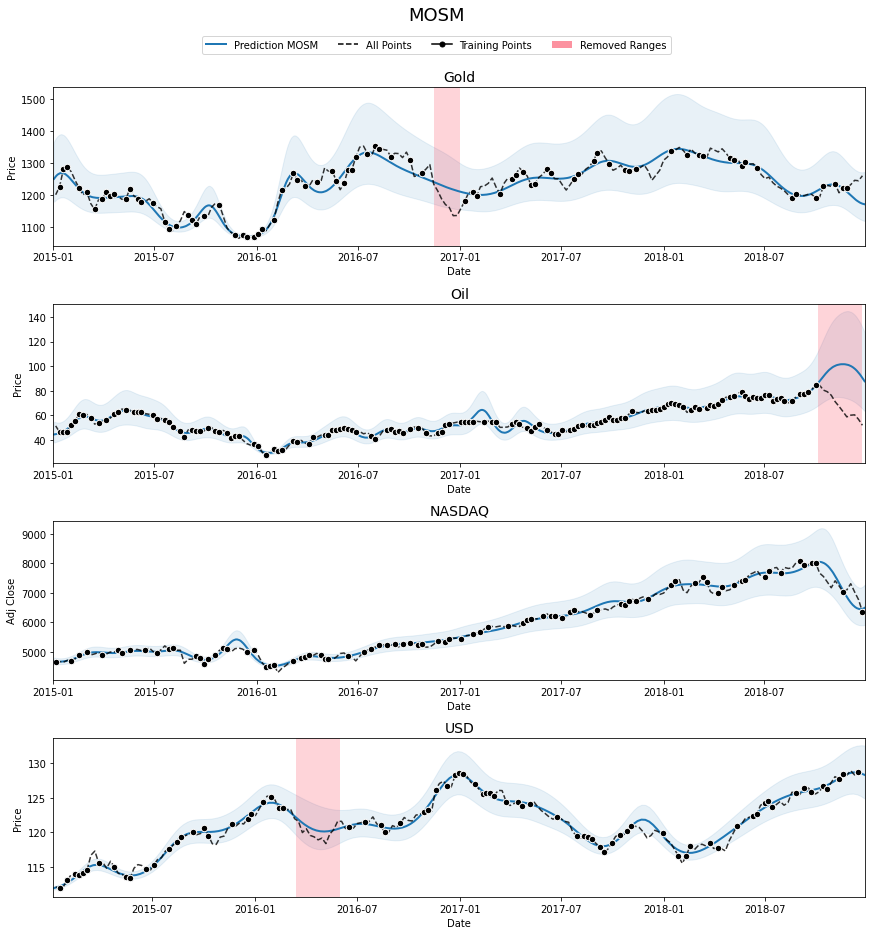

In [5]:
best_mosm = mosm_models[np.argmin(mosm_mape.mean(1))]
best_mosm.predict()
best_mosm.plot_prediction('MOSM');

### Auto-correlation and kernel evaluation at zero

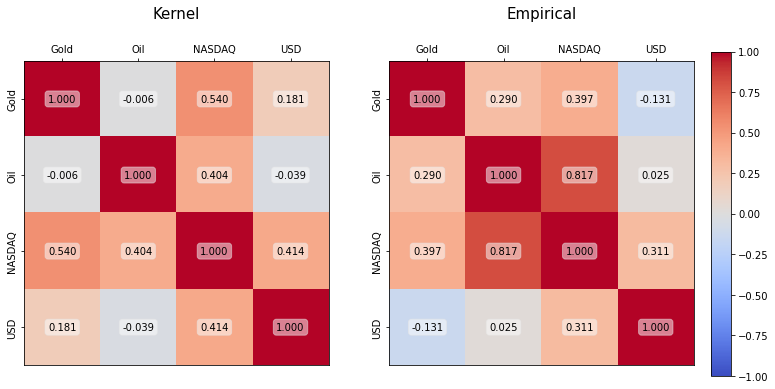

In [6]:
# Gram matrix
gram_matrix = best_mosm.get_gram_matrix(0, 0, n=1)

# autocorrelation
x_all, y_all = best_mosm.dataset.get_data()
y_all_array = np.empty((207, 0))
for y in y_all:
    y_all_array = np.c_[y_all_array, y[:207]]
auto_corr = np.corrcoef(y_all_array.T)

# normalize gram matrix
sqrt_diag = np.sqrt(np.diag(gram_matrix))
norm_gram_matrix = gram_matrix / np.outer(sqrt_diag, sqrt_diag)

f, axarray = plt.subplots(1, 2, figsize=(12, 8))
color_range = max(np.abs(norm_gram_matrix).max(), np.abs(auto_corr).max())

im = axarray[0].matshow(norm_gram_matrix, cmap='coolwarm', vmin=-color_range, vmax=color_range)
for (i, j), z in np.ndenumerate(norm_gram_matrix):
    axarray[0].text(j, i, '{:0.3f}'.format(z), ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='0.9'))
axarray[0].set_title('Kernel', y=1.12, fontsize=15)

im = axarray[1].matshow(auto_corr, cmap='coolwarm', vmin=-color_range, vmax=color_range)

for (i, j), z in np.ndenumerate(auto_corr):
    axarray[1].text(j, i, '{:0.3f}'.format(z), ha='center', va='center', 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='0.9'))
axarray[1].set_title('Empirical', y=1.12, fontsize=15)
axarray[0].set_yticks(np.arange(4));
axarray[0].set_yticklabels(dataset.get_names(), rotation=90, va='center');
axarray[0].set_xticks(np.arange(4));
axarray[0].set_xticklabels(dataset.get_names());
axarray[0].xaxis.set_ticks_position('top')

axarray[1].set_yticks(np.arange(4));
axarray[1].set_yticklabels(dataset.get_names(), rotation=90, va='center');
axarray[1].set_xticks(np.arange(4));
axarray[1].set_xticklabels(dataset.get_names());
axarray[1].xaxis.set_ticks_position('top')

cbar_ax = f.add_axes([.92, 0.22, 0.023, 0.563])
f.colorbar(im, cax=cbar_ax);

## Cross spectral mixture kernel

In [7]:
csm_models = []
csm_mae = np.zeros((n_trials,4))
csm_rmse = np.zeros((n_trials,4))
csm_mape = np.zeros((n_trials,4))

for n in range(n_trials):
    csm_dataset = dataset.copy()
    csm_dataset['Gold'].remove_randomly(pct=0.6)
    csm_dataset['Oil'].remove_randomly(pct=0.3)
    csm_dataset['NASDAQ'].remove_randomly(pct=0.6)
    csm_dataset['USD'].remove_randomly(pct=0.6)
    
    print('\nTrial', n+1, 'of', n_trials)
    csm = mogptk.CSM(csm_dataset, Q=3)
    csm.init_parameters('BNSE')    
    csm.train(method=method, lr=lr, iters=iters, verbose=True)
    csm_models.append(csm)
    print('=' * 50)
    
    error = mogptk.error(csm, per_channel=True)[0]
    csm_mae[n,:] = np.array([item['MAE'] for item in error])
    csm_rmse[n,:] = np.array([item['RMSE'] for item in error])
    csm_mape[n,:] = np.array([item['MAPE'] for item in error])
    
pd.DataFrame(np.c_[csm_mae.mean(0), csm_rmse.mean(0), csm_mape.mean(0),
             csm_mae.std(0), csm_rmse.std(0), csm_mape.std(0)],
             columns=['MAE', 'RMSE', 'MAPE', 'MAE std', 'RMSE std', 'MAPE std'])


Trial 1 of 5

Starting optimization using Adam
‣ Model: CSM
‣ Channels: 4
‣ Mixtures: 3
‣ Training points: 381
‣ Parameters: 42
‣ Initial NLL: 0.554

Optimization finished in 0.58 minutes
‣ Function evaluations: 500
‣ Final NLL: -0.187

Trial 2 of 5

Starting optimization using Adam
‣ Model: CSM
‣ Channels: 4
‣ Mixtures: 3
‣ Training points: 382
‣ Parameters: 42
‣ Initial NLL: 1.200

Optimization finished in 0.59 minutes
‣ Function evaluations: 500
‣ Final NLL: 0.136

Trial 3 of 5

Starting optimization using Adam
‣ Model: CSM
‣ Channels: 4
‣ Mixtures: 3
‣ Training points: 376
‣ Parameters: 42
‣ Initial NLL: 0.941

Optimization finished in 0.57 minutes
‣ Function evaluations: 500
‣ Final NLL: -0.104

Trial 4 of 5

Starting optimization using Adam
‣ Model: CSM
‣ Channels: 4
‣ Mixtures: 3
‣ Training points: 383
‣ Parameters: 42
‣ Initial NLL: 1.402

Optimization finished in 0.63 minutes
‣ Function evaluations: 500
‣ Final NLL: -0.121

Trial 5 of 5

Starting optimization using Adam
‣ Mod

,MAE,RMSE,MAPE,MAE std,RMSE std,MAPE std
0,146.681676,160.637800,11.618643,2.657532,2.588827,0.184069
1,18.353689,21.188765,29.530277,0.727964,0.826867,0.728975
2,1569.286646,1893.133463,24.336768,74.739297,71.061359,0.892483
3,3.844980,4.703595,3.127456,0.120297,0.122843,0.093839


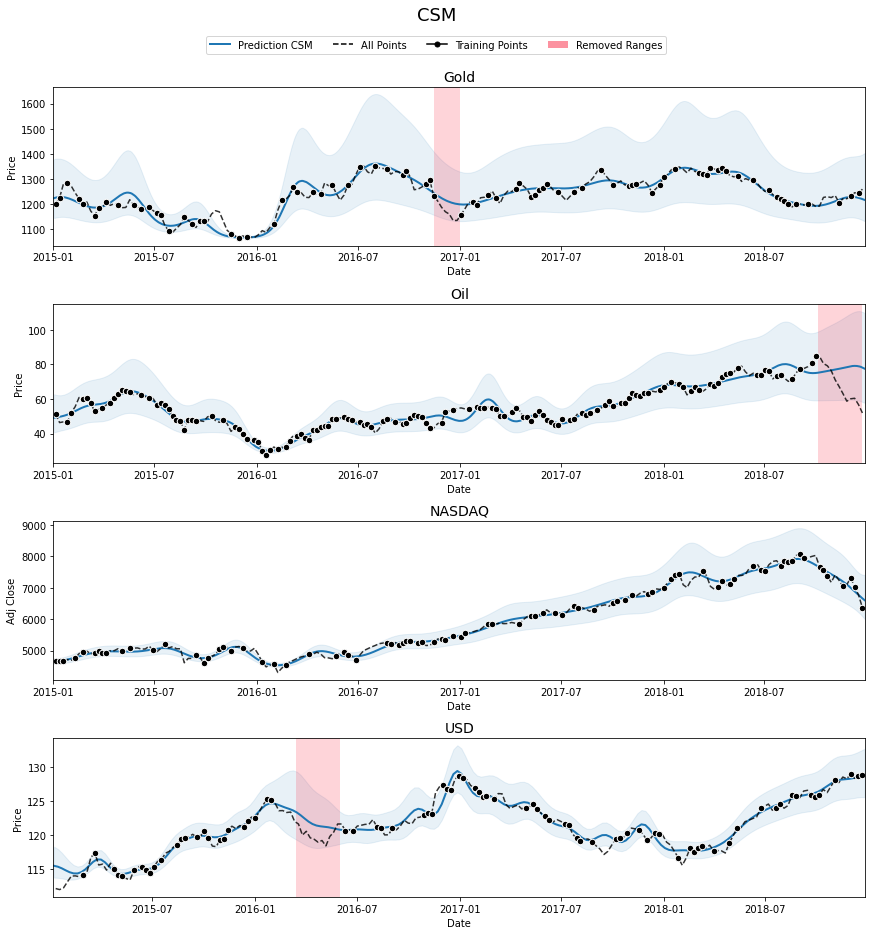

In [8]:
best_csm = csm_models[np.argmin(csm_mape.mean(1))]
best_csm.predict()
best_csm.plot_prediction('CSM');

## Linear model of coregionalization with spectral mixture kernels

In [9]:
smlmc_models = []
smlmc_mae = np.zeros((n_trials,4))
smlmc_rmse = np.zeros((n_trials,4))
smlmc_mape = np.zeros((n_trials,4))

for n in range(n_trials):
    smlmc_dataset = dataset.copy()
    smlmc_dataset['Gold'].remove_randomly(pct=0.6)
    smlmc_dataset['Oil'].remove_randomly(pct=0.3)
    smlmc_dataset['NASDAQ'].remove_randomly(pct=0.6)
    smlmc_dataset['USD'].remove_randomly(pct=0.6)
    
    print('\nTrial', n+1, 'of', n_trials)
    smlmc = mogptk.SM_LMC(smlmc_dataset, Q=3)
    smlmc.init_parameters('BNSE')
    smlmc.train(method=method, lr=lr, iters=iters, verbose=True)
    smlmc_models.append(smlmc)
    print('=' * 50)

    error = mogptk.error(smlmc, per_channel=True)[0]
    smlmc_mae[n,:] = np.array([item['MAE'] for item in error])
    smlmc_rmse[n,:] = np.array([item['RMSE'] for item in error])
    smlmc_mape[n,:] = np.array([item['MAPE'] for item in error])
    
pd.DataFrame(np.c_[smlmc_mae.mean(0), smlmc_rmse.mean(0), smlmc_mape.mean(0),
             smlmc_mae.std(0), smlmc_rmse.std(0), smlmc_mape.std(0)],
             columns=['MAE', 'RMSE', 'MAPE', 'MAE std', 'RMSE std', 'MAPE std'])


Trial 1 of 5

Starting optimization using Adam
‣ Model: SM-LMC
‣ Channels: 4
‣ Mixtures: 3
‣ Training points: 380
‣ Parameters: 22
‣ Initial NLL: 4.159

Optimization finished in 0.36 minutes
‣ Function evaluations: 500
‣ Final NLL: 0.048

Trial 2 of 5

Starting optimization using Adam
‣ Model: SM-LMC
‣ Channels: 4
‣ Mixtures: 3
‣ Training points: 378
‣ Parameters: 22
‣ Initial NLL: 1.677

Optimization finished in 0.39 minutes
‣ Function evaluations: 500
‣ Final NLL: -0.017

Trial 3 of 5

Starting optimization using Adam
‣ Model: SM-LMC
‣ Channels: 4
‣ Mixtures: 3
‣ Training points: 380
‣ Parameters: 22
‣ Initial NLL: 2.563

Optimization finished in 0.38 minutes
‣ Function evaluations: 500
‣ Final NLL: 0.078

Trial 4 of 5

Starting optimization using Adam
‣ Model: SM-LMC
‣ Channels: 4
‣ Mixtures: 3
‣ Training points: 384
‣ Parameters: 22
‣ Initial NLL: 2.560

Optimization finished in 0.39 minutes
‣ Function evaluations: 500
‣ Final NLL: 0.328

Trial 5 of 5

Starting optimization using 

,MAE,RMSE,MAPE,MAE std,RMSE std,MAPE std
0,147.361910,161.638188,11.666825,4.670454,4.314946,0.347770
1,17.749545,20.589901,28.943962,0.518925,0.347193,0.729595
2,1568.374756,1892.749242,24.360675,29.896630,28.941811,0.384150
3,3.966727,4.871953,3.218741,0.086715,0.103743,0.068008


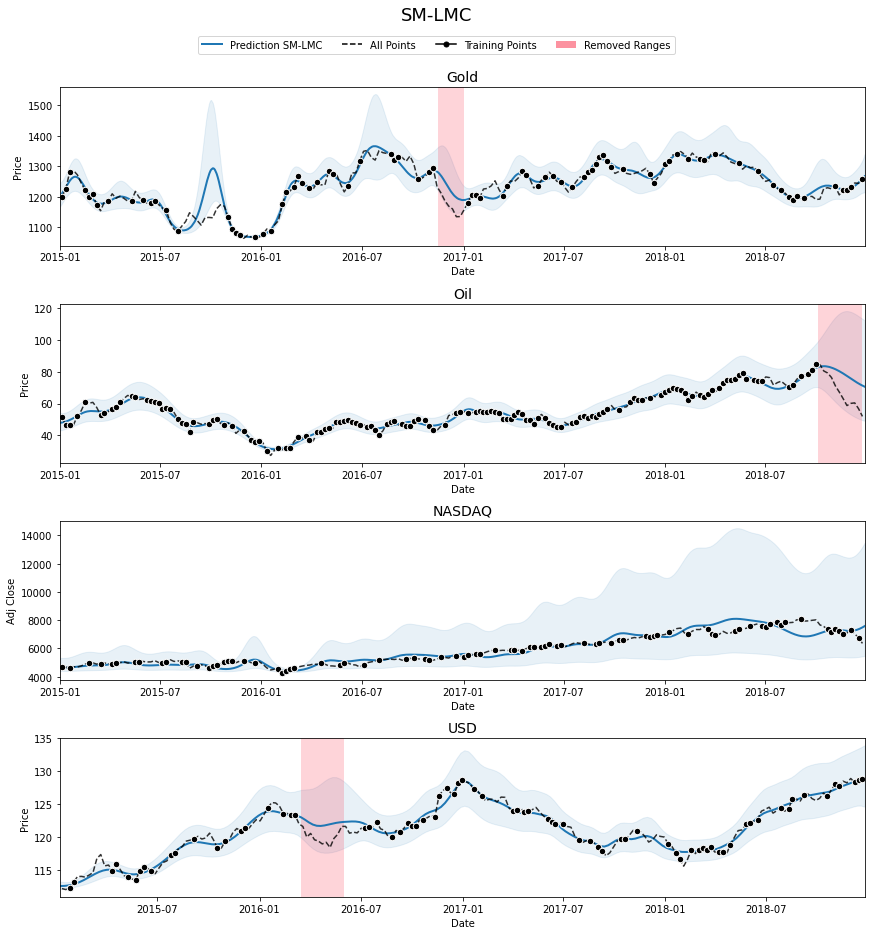

In [10]:
best_smlmc = smlmc_models[np.argmin(smlmc_mape.mean(1))]
best_smlmc.predict()
best_smlmc.plot_prediction('SM-LMC');

# Independent spectral mixture kernels

In [11]:
sm_models = []
sm_mae = np.zeros((n_trials,4))
sm_rmse = np.zeros((n_trials,4))
sm_mape = np.zeros((n_trials,4))

for n in range(n_trials):
    sm_dataset = dataset.copy()
    sm_dataset['Gold'].remove_randomly(pct=0.6)
    sm_dataset['Oil'].remove_randomly(pct=0.3)
    sm_dataset['NASDAQ'].remove_randomly(pct=0.6)
    sm_dataset['USD'].remove_randomly(pct=0.6)
    
    print('\nTrial', n+1, 'of', n_trials)
    sm = mogptk.SM(sm_dataset, Q=3)
    sm.init_parameters('BNSE')
    sm.train(method=method, lr=lr, iters=iters, verbose=True)
    sm_models.append(sm)
    print('=' * 50)
        
    error = mogptk.error(sm, per_channel=True)[0]
    sm_mae[n,:] = np.array([item['MAE'] for item in error])
    sm_rmse[n,:] = np.array([item['RMSE'] for item in error])
    sm_mape[n,:] = np.array([item['MAPE'] for item in error])
    
pd.DataFrame(np.c_[sm_mae.mean(0), sm_rmse.mean(0), sm_mape.mean(0),
             sm_mae.std(0), sm_rmse.std(0), sm_mape.std(0)],
             columns=['MAE', 'RMSE', 'MAPE', 'MAE std', 'RMSE std', 'MAPE std'])


Trial 1 of 5

Starting optimization using Adam
‣ Model: SM
‣ Channels: 4
‣ Mixtures: 3
‣ Training points: 381
‣ Parameters: 40
‣ Initial NLL: 1.224

Optimization finished in 0.23 minutes
‣ Function evaluations: 500
‣ Final NLL: 0.288

Trial 2 of 5

Starting optimization using Adam
‣ Model: SM
‣ Channels: 4
‣ Mixtures: 3
‣ Training points: 383
‣ Parameters: 40
‣ Initial NLL: 1.206

Optimization finished in 0.23 minutes
‣ Function evaluations: 500
‣ Final NLL: 0.168

Trial 3 of 5

Starting optimization using Adam
‣ Model: SM
‣ Channels: 4
‣ Mixtures: 3
‣ Training points: 379
‣ Parameters: 40
‣ Initial NLL: 1.212

Optimization finished in 0.23 minutes
‣ Function evaluations: 500
‣ Final NLL: 0.189

Trial 4 of 5

Starting optimization using Adam
‣ Model: SM
‣ Channels: 4
‣ Mixtures: 3
‣ Training points: 384
‣ Parameters: 40
‣ Initial NLL: 1.147

Optimization finished in 0.25 minutes
‣ Function evaluations: 500
‣ Final NLL: -0.172

Trial 5 of 5

Starting optimization using Adam
‣ Model: SM

,MAE,RMSE,MAPE,MAE std,RMSE std,MAPE std
0,144.421931,159.127840,11.447755,4.057055,3.703944,0.295631
1,17.858669,20.497544,29.224090,0.978345,0.979717,1.085020
2,1584.681215,1914.930683,24.499576,35.165243,34.101717,0.427256
3,4.049965,4.854823,3.290547,0.127771,0.135831,0.101693


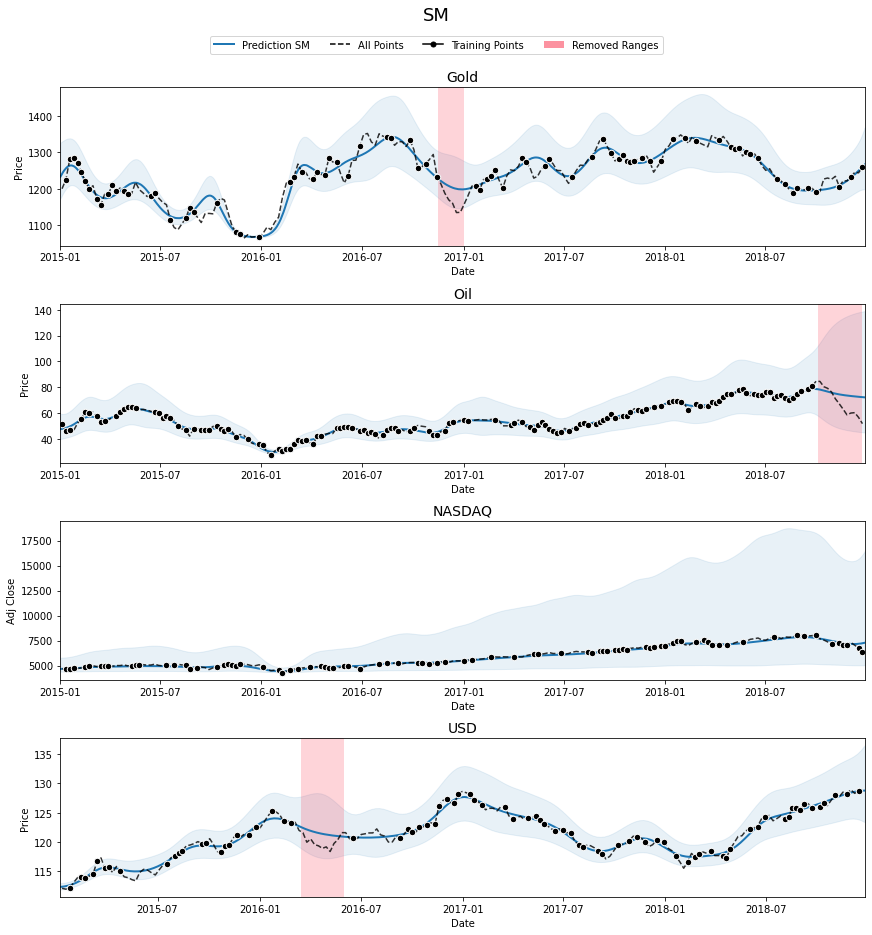

In [12]:
best_sm = sm_models[np.argmin(sm_mape.mean(1))]
best_sm.predict()
best_sm.plot_prediction('SM');

## Results

In [13]:
print('MAPE errors per model')
print('MOSM:    %g ± %g' % (mosm_mape.mean(1).mean(), mosm_mape.mean(1).std()))
print('CSM:     %g ± %g' % (csm_mape.mean(1).mean(), csm_mape.mean(1).std()))
print('SM-LMC:  %g ± %g' % (smlmc_mape.mean(1).mean(), smlmc_mape.mean(1).std()))
print('SM:      %g ± %g' % (sm_mape.mean(1).mean(), sm_mape.mean(1).std()))

MAPE errors per model
MOSM:    16.8355 ± 0.435494
CSM:     17.1533 ± 0.16501
SM-LMC:  17.0476 ± 0.301511
SM:      17.1155 ± 0.292003
